# Inverse Compton Scattering

All things related to ICS.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
 %reload_ext autoreload

In [3]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import definitions as phys

from matplotlib.colors import LogNorm

# import special functions

from scipy.special import spence
from scipy.special import bernoulli, zeta
from scipy.special import exp1

In [4]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "arial",
    'font.size': 14
})

We will describe the differential spectra for an isotropic black body spectra, and isotropic electron distribution. The easiest way to do this is described by [A. Zdziarski and P. Pjanka 2013](https://inspirehep.net/literature/1244496) (see eq.29).

### Special Functions for Bose-Einstein Integrals

These special functions are analytical/numerical estimates for Bose-Einstein integrals that apear in differential spectra, defined here with nomenclature "special_func_X". These special functions can still be the greatest source of numerical error so one has to be careful.

In [5]:
def special_func_0(x):
    return -np.log(1 - np.exp(-x))

In [6]:
def special_func_1(x):
    return (spence(1 - np.exp(-x)) - x*np.log(1 - np.exp(-x)))

In [7]:
def g_l(x):
    
   # Calculate the sum with Bernoulli numbers
    b1 = 1/12
    b2 = -1/720
    b3 = 1/30240

    # Corrected equation for sum
    sum = (-1/x - np.log(x)/2 + 
           x*b1 + b2*x**3/3 + b3*x**5/5)

    return sum

def g_h(x):
    return exp1(x) + exp1(2*x) + exp1(3*x)
    
def special_func_minus1(x):
    q = 2.257
    g0 = 0.0366377
    
    x=np.asarray(x)

    return np.where(x<=q, g_l(q) - g_l(x) + g0, g_h(x))

In [8]:
def h_l(x):

    # Calculate the sum with Bernoulli numbers
    b1 = 1/12
    b2 = -1/720
    b3 = 1/30240

    sum = ( (x*(1-np.log(x)) + (np.log(x))**2)/2 +
           b1*x**2 *(2*np.log(x) - 1)/4 + 
           b2*x**4 *(4*np.log(x) - 1)/16 +
           b3*x**6 *(6*np.log(x) - 1)/36 )
    
    return sum

def h_h(x):
    # Corrected equation with necessary multiplication signs and proper syntax
    sum = (exp1(x) + np.exp(-x) * np.log(x) + 
           (exp1(2 * x) + np.exp(-2 * x) * np.log(x)) / 2 + 
           (exp1(3 * x) + np.exp(-3 * x) * np.log(x)) / 3)
    
    return sum

def special_func_ln(x):
    q = 2.257
    h0 = 0.125505

    x = np.asarray(x)

    return np.where(x <= q, h_l(q) - h_l(x) + h0, h_h(x))

### Test Functions for Differential Spectra

With these special functions, we first want to reproduce functional form shown in Zdziarsky's paper fig.3a-c. We create two test functions:
1. Full form. This takes into account both Klein-Nishina and Thomson limit for ICS scattering, defined by the parameter
    $$
    \epsilon_n \equiv \frac{\epsilon_1}{4 \gamma (\gamma - \epsilon_1)} \ ,
    $$
    where $\epsilon_1 = E_1 / m_e c^2$ and $\gamma = E_e / m_e c^2$. 

2. Thomson limit which simply implies dropping terms of $2 \epsilon_1 \epsilon_n$ and taking the limit $\epsilon_n \to \epsilon_1 / 4 \gamma^2$. 

In [9]:
def test_func_full(gamma, ep1): 
    A = 1
    theta = 3e-5

    # Take the arguments of the function as np arrays
    gamma = np.asarray(gamma)
    ep1 = np.asarray(ep1)

    # Set a threshold for the eps_n parameter
    threshold_min = 1e-10
    threshold_max = 1e+10
    offset = 1e-15 # removes division by 0

    """
    Note that I've added three values to make life much easier. 
    #########################
    A threshold_min value to return in case function becomes too small (unlikely).

    ##########################
    A threshold_max value to return in case function becomes too large. 
    This can be caused by the divergent term in the denominator.
    Since we are comparing normalized electron and scattered photon energies a value of 1e+10 should be okay.

    #########################
    An offset value that bypasses the issue of division by 0 altogether.
    This value is set to 1e-15 which should be okay since again the parameters are energies normalized to electron mass. 
    This offset also resolves all of the numerical errors encountered while calling the special functions. 
    """
    
    # Define characteristic energy
    eps_n = np.clip(ep1 / 4 / gamma / (gamma - ep1 + offset), threshold_min, threshold_max) 

    # Break the sum into 4 parts
    p1 = (1 - 2*ep1*eps_n + 2*np.log(eps_n / theta)) * eps_n * theta * special_func_0(eps_n / theta)

    p2 = (1 + 2*ep1*eps_n) * theta**2 * special_func_1(eps_n/theta)

    p3 = -2 * eps_n**2 *special_func_minus1(eps_n / theta)

    p4 = -2 * eps_n * theta * special_func_ln(eps_n / theta)

    return np.where(ep1 < gamma, (3  * 1 / 4 / gamma**2)* (p1 + p2 + p3 + p4), 0)

In [70]:
def test_func_thomson(gamma, ep1): 
    A = 1
    theta = 3e-5

    # Take the arguments of the function as np arrays
    gamma = np.asarray(gamma)
    ep1 = np.asarray(ep1)

    # Define characteristic energy
    eps_n = ep1 /4 /gamma**2
    # Break the sum into 4 parts
    p1 = (1 + 2*np.log(eps_n / theta)) * eps_n * theta * special_func_0(eps_n / theta)

    p2 = (1) * theta**2 * special_func_1(eps_n/theta)

    p3 = -2 * eps_n**2 *special_func_minus1(eps_n / theta)

    p4 = -2 * eps_n * theta * special_func_ln(eps_n / theta)

    return (3  * 1 / 4 / gamma**2)* (p1 + p2 + p3 + p4)

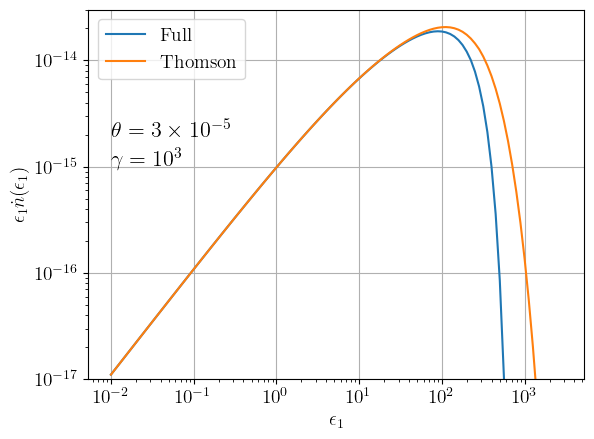

In [86]:
# Try plotting fig.3a in Zdziarsky's paper
ep1_list = 10**np.arange(-2,3.5,0.05)

plt.figure()
plt.plot(ep1_list, ep1_list*test_func_full(1e+3, ep1_list), label='Full')
plt.plot(ep1_list, ep1_list*test_func_thomson(1e+3, ep1_list), label='Thomson')

plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-17, 3e-14)
plt.legend()
plt.grid()
plt.xlabel(r'$\epsilon_1$')
plt.ylabel(r'$\epsilon_1 \dot{n} (\epsilon_1)$')
plt.text(1e-2, 2e-15, r'$\theta = 3 \times 10^{-5}$',fontsize=16)
plt.text(1e-2, 1e-15, r'$\gamma = 10^3$', fontsize=16)


plt.savefig('/Users/yash/Desktop/SubGeVDCBH/FirstLightCode/plots/Zdziarsky_low_eng.png')


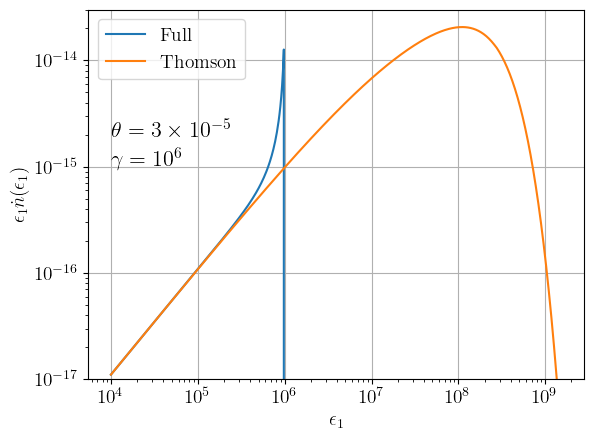

In [85]:
# Try plotting fig.3b in Zdiarsky's paper

ep1_list = 10**np.arange(4,9.2,0.01)

plt.figure()
plt.plot(ep1_list, ep1_list * test_func_full(1e+6, ep1_list), label='Full' )
plt.plot(ep1_list, ep1_list * test_func_thomson(1e+6, ep1_list), label='Thomson' )

plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-17, 3e-14)
plt.legend()
plt.xlabel(r'$\epsilon_1$')
plt.ylabel(r'$\epsilon_1 \dot{n} (\epsilon_1)$')
plt.text(1e+4, 2e-15, r'$\theta = 3 \times 10^{-5}$',fontsize=16)
plt.text(1e+4, 1e-15, r'$\gamma = 10^6$', fontsize=16)
plt.grid()

plt.savefig('/Users/yash/Desktop/SubGeVDCBH/FirstLightCode/plots/Zdziarsky_high_eng.png')

Both of these tests pass well! We can now move on to the actual ICS spectra. Create a test linear space for electron and photon energies.

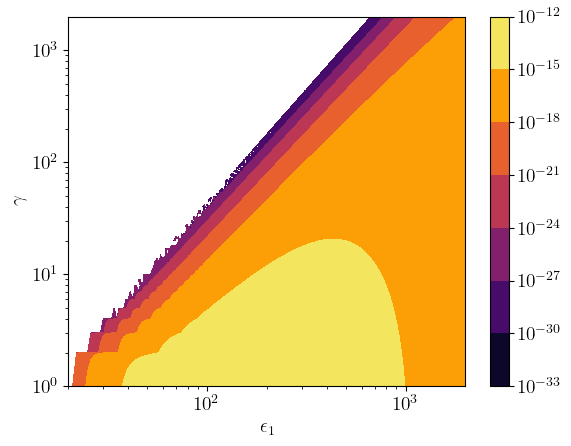

In [13]:
# Now try plotting over a range of parameter space in gamma and energy
# First Thomson assumption
gamma_list = np.arange(20,2000)
ep1_list = np.arange(1,2000)

# Create a meshgrid
X, Y = np.meshgrid (gamma_list, ep1_list)

Vals_Thomson = test_func_thomson(X, Y)
Vals_Thomson[Vals_Thomson <= 0] =np.nan

plt.figure()
plt.loglog()
plt.contourf(X, Y, Vals_Thomson, cmap = 'inferno',
            norm = LogNorm())
plt.colorbar()
plt.xlabel(r'$\epsilon_1$')
plt.ylabel(r'$\gamma$')
plt.show()

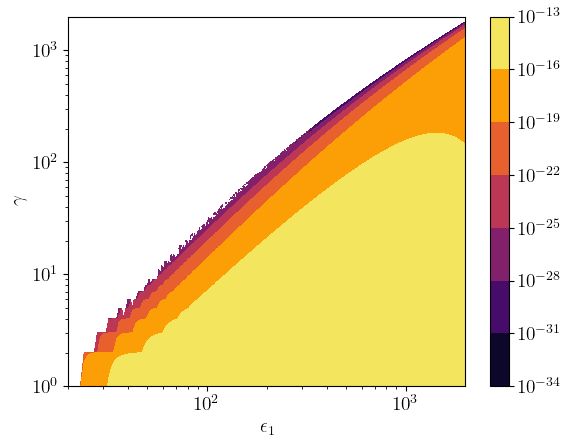

In [14]:
# Now try plotting over a range of parameter space in gamma and energy
# First Thomson assumption
gamma_list = np.arange(20,2000)
ep1_list = np.arange(1,2000)

# Create a meshgrid
X, Y = np.meshgrid (gamma_list, ep1_list)

Vals_Thomson = test_func_full(X, Y)
Vals_Thomson[Vals_Thomson <= 0] =np.nan

plt.figure()
plt.loglog()
plt.contourf(X, Y, Vals_Thomson, cmap = 'inferno',
            norm = LogNorm())
plt.colorbar()
plt.xlabel(r'$\epsilon_1$')
plt.ylabel(r'$\gamma$')
plt.show()

### Inverse Compton Differential Spectra

Now, we can move on to the complete differential spectra. To do this we will follow the notation of Zdziarsky i.e. the differential spectra function will input three parameters:

1. Radiation temperature , $T_r$.
    
2. Electron kinetic energy, $E_e$, for $E_e \gg m_e c^2$. The case of $E_e \sim m_e c^2$ needs to be handled seperately.

3. Scattered photon energy $E_1$. Kinematics require $E_1 < E_e$.

In [21]:
# Define differential spectra

def dN_dtdE1(Tr, elec_energy, phot_energy):

    """
    Note here there is an extra factor of 1/m_e c^2 in the denominator of A.
    This gives the output differential spectra in units of eV^(-1) s^(-1).

    The where statement in return ensures that only photons below maximum electron energy are produced.
    """

    # Take the arguments of the function as np arrays
    gamma = np.asarray(elec_energy) / phys.me_eV
    ep1 = np.asarray(phot_energy) / phys.me_eV

    # Set a threshold for the eps_n parameter
    threshold_min = 1e-10
    threshold_max = 1e+10
    offset = 1e-15 # removes division by 0
    
    # Define characteristic energy
    eps_n = np.clip(ep1 / 4 / gamma / (gamma - ep1 + offset), threshold_min, threshold_max) 

    # Define quantites according to paper
    
    A = 8*np.pi* (phys.me_eV / phys.h_planck / phys.cs)**3 / phys.me_eV
    theta = phys.kB * Tr / phys.me_eV

    # Break the sum into 4 parts
    p1 = (1 - 2*ep1*eps_n + 2*np.log(eps_n / theta)) * eps_n * theta * special_func_0(eps_n / theta)

    p2 = (1 + 2*ep1*eps_n) * theta**2 * special_func_1(eps_n/theta)

    p3 = -2 * eps_n**2 *special_func_minus1(eps_n / theta)

    p4 = -2 * eps_n * theta * special_func_ln(eps_n / theta)

    return np.where(ep1 < gamma, 3*phys.sigma_th*phys.cs*A / 4 / gamma**2 * (p1 + p2 + p3 + p4), 0 )

In [22]:
dN_dtdE1(100,1e+7, 1e+2)

array(1.61941433e-11)

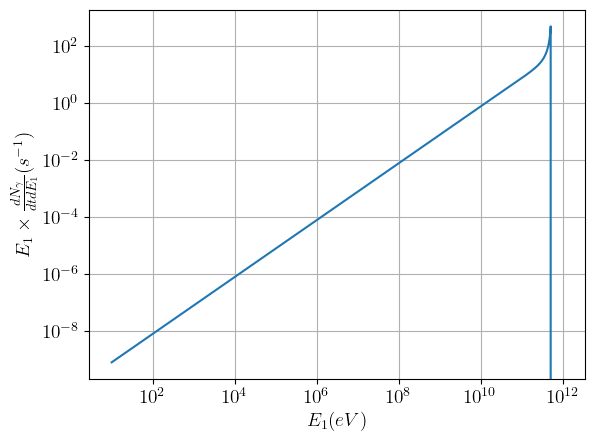

In [23]:
# Try reproducing similar function shape as Zdziarsky
ep1_list = 10**np.arange(1,12,0.01) # eV
temp_ref = 3e-5 * phys.me_eV / phys.kB
elec_ref = 1e+6 * phys.me_eV #

plt.figure()
plt.plot(ep1_list, ep1_list*dN_dtdE1(temp_ref, elec_ref, ep1_list) )

plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$E_1 (eV)$')
plt.ylabel(r'$E_1 \times \frac{dN_\gamma}{dt d E_1} (s^{-1})$')
plt.grid()
plt.show()

This reproduces the functional form for Klein-Nishina regime well. Now let's try a few different $\gamma$ at z=50.

In [24]:
# Define energy range for scattered photon
E_min = np.log10(1)
E_max = np.log10(1e+10) #  10 GeV / m_e c^2

E1_list = 10**np.arange(E_min, E_max, 0.01)


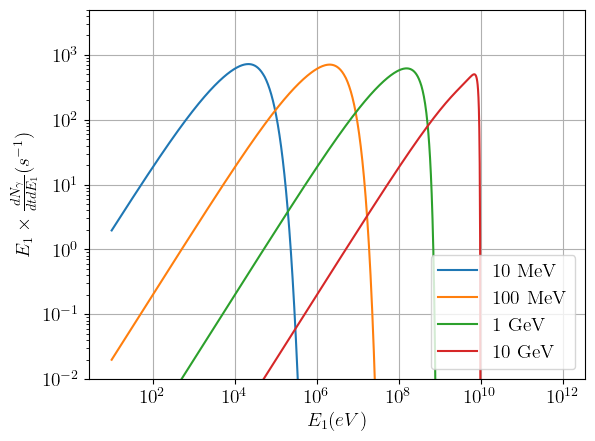

In [25]:
# Plot ICS spectra at reference temperature defined in previous cell to check range of photon energies.

plt.figure()

plt.plot(ep1_list, ep1_list* dN_dtdE1(temp_ref, 1e+7, ep1_list), label='10 MeV' ) # 10 MeV electron
plt.plot(ep1_list, ep1_list* dN_dtdE1(temp_ref, 1e+8, ep1_list), label='100 MeV' ) # 100 MeV electron
plt.plot(ep1_list, ep1_list* dN_dtdE1(temp_ref, 1e+9, ep1_list), label='1 GeV' ) # 1 GeV electron
plt.plot(ep1_list, ep1_list* dN_dtdE1(temp_ref, 1e+10, ep1_list), label='10 GeV' ) # 10 GeV electron

plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-2, 5e+3)
plt.grid()
plt.xlabel(r'$E_1 (eV)$')
plt.ylabel(r'$E_1 \times \frac{dN_\gamma}{dt d E_1} (s^{-1})$')
plt.legend()
plt.show()

Note the photons at temp_ref = $1.78 \times 10^6 \, K$ produces photons close to the electron energy as well. So at this point we can fairly conclude that the code passes tests from Zdziarsky's paper.

### Reproducing Dark History Spectra

The last step now is to reproduce [DarkHistory](https://arxiv.org/pdf/1904.09296) ICS spectra, shown in Fig.10 (Thomson), and Fig. 11 (relativistic).

In [105]:
# Test Thomson part first
elec_en_list = 10**np.arange(0,8,0.01)
phot_en_list = 10**np.arange(-8,8,0.01)

X, Y = np.meshgrid(elec_en_list, phot_en_list)

vals_thomson = dN_dtdE1(0.25 / phys.kB , X, Y)
vals_thomson[vals_thomson <= 0] =np.nan

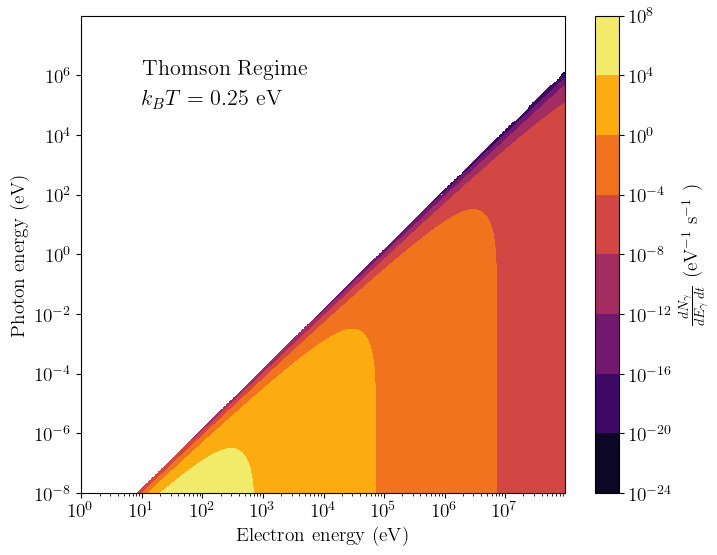

In [106]:
# Now plot 

plt.figure(figsize=(7.8, 6.2))
plt.contourf(X, Y, vals_thomson, 
            norm = LogNorm(),
            cmap = 'inferno',)
plt.loglog()
plt.colorbar(label=r'$\frac{dN_\gamma}{dE_\gamma \, dt}$ (eV$^{-1}$ s$^{-1}$ )')
plt.xlabel(r'Electron energy (eV)')
plt.ylabel(r'Photon energy (eV)')
plt.text(1e+1, 1e+6, 'Thomson Regime', fontsize=16)
plt.text(1e+1, 1e+5, r'$k_B T = 0.25$ eV', fontsize=16)

plt.show()
plt.savefig('/Users/yash/Desktop/SubGeVDCBH/FirstLightCode/plots/Thomson_DarkHistory.png')
plt.close()

In [107]:
# Relativistic regime

elec_en_list = 10**np.arange(8,14,0.01)
phot_en_list = 10**np.arange(-8,15,0.01)

X, Y = np.meshgrid(elec_en_list, phot_en_list)

vals_rel = dN_dtdE1(0.25 / phys.kB , X, Y)
vals_rel[vals_rel <= 0] =np.nan

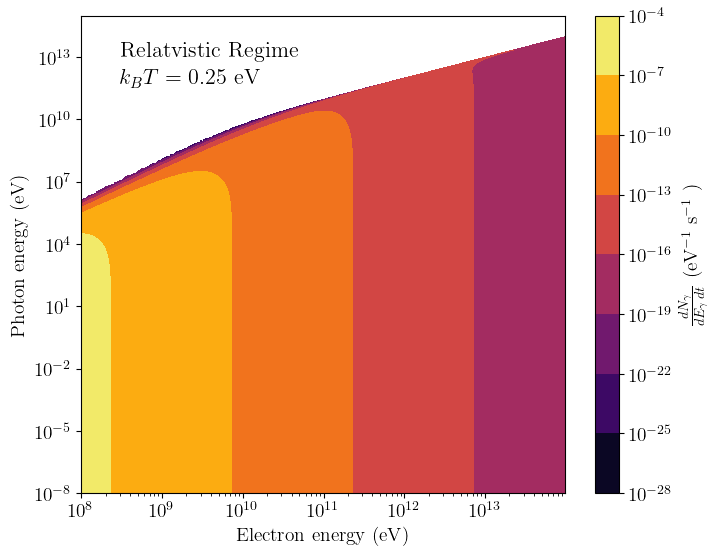

In [108]:
# Now plot 

plt.figure(figsize=(7.8, 6.2))
plt.contourf(X, Y, vals_rel, 
            norm = LogNorm(),
            cmap = 'inferno',)
plt.loglog()
plt.xlabel(r'Electron energy (eV)')
plt.ylabel(r'Photon energy (eV)')
plt.colorbar(label=r'$\frac{dN_\gamma}{dE_\gamma \, dt}$ (eV$^{-1}$ s$^{-1}$ )')
plt.text(3e+8, 1e+13, 'Relatvistic Regime', fontsize=16)
plt.text(3e+8, 5e+11, r'$k_B T = 0.25$ eV', fontsize=16)

plt.show()
plt.savefig('/Users/yash/Desktop/SubGeVDCBH/FirstLightCode/plots/Relativistic_DarkHistory_2.png')
plt.close()